In [1]:
import pandas as pd
import numpy as np
import os 
import cv2
from skimage.io import ImageCollection
from skimage.io import imread,imshow
from utils_detector import DataGenerator
import matplotlib.pyplot as plt
import keras.callbacks
%matplotlib inline

/home/wvillegas/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
dataset = pd.read_csv(os.path.join('/home','wvillegas','dataset-mask', 'full_masks.csv'))

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset['orig'],dataset['mask'],
                                                    test_size = 0.2, random_state=1)

In [5]:
partition = {'train':list(X_train),
             'test': list(X_test)}

In [6]:
img_list = list(X_train) + list(X_test)
mask_list = list(Y_train) + list(Y_test)

In [7]:
labels = dict(zip(img_list, mask_list))

In [8]:
masks_path = os.path.join('/home','wvillegas','dataset-mask','masks')
img_path = os.path.join('/home','wvillegas','dataset-mask','images')

In [9]:
batch_size = 1
dim_img = (1728, 2304)
dim_mask = (658,874)

In [10]:
train_generator = DataGenerator(batch_size=batch_size,dim=dim_img,dim_label=dim_mask,img_path=img_path,
                                labels=labels,list_IDs=partition['train'],n_channels=3,
                                n_channels_label=1,shuffle=True,mask_path=masks_path)
valid_generator = DataGenerator(batch_size=batch_size,dim=dim_img,dim_label=dim_mask,img_path=img_path,
                                labels=labels,list_IDs=partition['test'],n_channels=3,
                                n_channels_label=1,shuffle=True,mask_path=masks_path)

In [ ]:
# Xtrain = []
# Xtest = []
# Ytrain = []
# Ytest = []
# for i in (X_train.index):
#     Xtrain.append(imread(img_path + '/' + X_train[i]))
#     Ytrain.append(imread(masks_path + '/' + Y_train[i]))
# for i in (X_test.index):
#     Xtest.append(imread(img_path + '/' + X_test[i]))
#     Ytest.append(imread(masks_path + '/' + Y_test[i]))

In [ ]:
# for i in np.arange(num_samples):
#     X[i] = cv2.resize(X[i],(0,0), fx=0.5, fy=0.5)
#     Y[i] = cv2.resize(Y[i],(874,658))    
#     Y[i] = cv2.cvtColor(Y[i], cv2.COLOR_BGR2GRAY)
#     Y[i] = Y[i].astype(bool).astype(int)
#     Y[i] = np.expand_dims(Y[i], axis=2)

In [ ]:
# imshow(X[0])

In [ ]:
# imshow(Y[0][:,:,0])

In [11]:
from keras.applications import VGG16
from keras.layers import Conv2DTranspose,Conv2D, Add, Cropping2D
from keras import Model
from keras.models import load_model

In [12]:
# mobilenet = MobileNet(include_top=False,weights='imagenet')

In [14]:
net = VGG16(include_top=False, weights='imagenet')
# net.load_weights('/home/wvillegas/DLProjects/BudClassifier/cmdscripts/modelosV2/mobilenet_weights_detection.h5', by_name=True)

In [13]:
# t1 = Conv2DTranspose(1,activation='relu',kernel_size=4)(mobilenet.output)
# t2 = Conv2DTranspose(1,activation='relu',kernel_size=8)(t1)
# t3 = Conv2DTranspose(1,activation='relu',kernel_size=16)(t2)

# fin = Conv2D(1,1,activation='sigmoid')(t3)

In [ ]:
net.summary()

In [15]:
# test arquitectura paper de FCN 
# deconv1 = Conv2D(filters=256,kernel_size=3,strides=1,activation='relu')(mobilenet.output)
predict = Conv2D(filters=1,kernel_size=1,strides=1)(net.output)
deconv1 = Conv2DTranspose(filters=512,kernel_size=4,strides=2, padding='same')(predict)
crop1 = Cropping2D(cropping=((0,0),(0,1)))(net.get_layer('block4_pool').output)
add1 = Add()([deconv1, crop1])
deconv2 = Conv2DTranspose(filters=1,kernel_size=32,strides=16,padding='same')(add1)

In [16]:
fcn = Model(inputs=net.input,outputs=deconv2)

In [ ]:
# fcn.summary()

In [ ]:
# for layer in fcn.layers:
#     layer.trainable = False

In [ ]:
# for layer in fcn.layers:
#     print(layer.trainable)

In [ ]:
# plt.imshow(pred[0,:,:,0], cmap="gray")

In [ ]:
# Xtrain = np.asarray(Xtrain)
# Ytrain = np.asarray(Ytrain)
# Xtest = np.asarray(Xtest)
# Ytest = np.asarray(Ytest)

In [ ]:
from keras.callbacks import Callback

In [ ]:
class LossAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
        self.val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get['acc'])
        self.val_acc.append(logs.get['val_acc'])
        

In [ ]:
# callback = LossAccHistory()

In [17]:
from keras.optimizers import SGD, RMSprop

In [24]:
sgd = SGD(lr=0.01,momentum=0.9)
fcn.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=3, min_lr=0.00001)

In [ ]:
history = fcn.fit_generator(generator=train_generator,validation_data=valid_generator,
                            use_multiprocessing=True,workers=6, epochs=1)

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [121]:
list_img = partition['test'][93:94]

In [122]:
inp_img = []
for img in list_img:
    temp = cv2.imread(img_path + '/' + img)
    temp = cv2.resize(temp, (0,0), fx=0.5, fy=0.5)
#   temp = cv2.normalize(temp, temp, 0, 255, cv2.NORM_MINMAX)
    inp_img.append(temp)
    
ground_truth = []
for img in list_img:
    mask = labels[img]
    print(mask)
    temp = cv2.imread(masks_path + '/' + mask)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    temp = temp.astype(bool).astype(int)
    ground_truth.append(temp)


mask_0437.png


In [123]:
for i in np.arange(len(inp_img)):
    print(inp_img[i].shape)

(1728, 1728, 3)


In [125]:
inp_img = np.asarray(inp_img)
ground_truth = np.asarray(ground_truth)

In [67]:
inp_img.shape

(1, 1728, 2304, 3)

In [126]:
pred = fcn.predict(inp_img)

InvalidArgumentError: Incompatible shapes: [1,512,108,108] vs. [1,512,108,107]
	 [[Node: add_1/add = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_transpose_1/BiasAdd, cropping2d_1/strided_slice)]]

In [ ]:
# img = cv2.imread(img_path + '/0717.jpg')
# img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
# img.shape

In [ ]:
# xx = np.empty((1,img.shape[0],img.shape[1], 3))
# xx[0,] = img

In [ ]:
# pred = fcn.predict(xx)
# pred.shape

In [62]:
pred.shape

(1, 1824, 2720, 1)

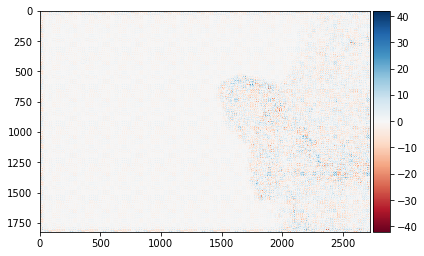

In [27]:
imshow(pred[0,:,:,0])

In [ ]:
ground_truth.shape

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


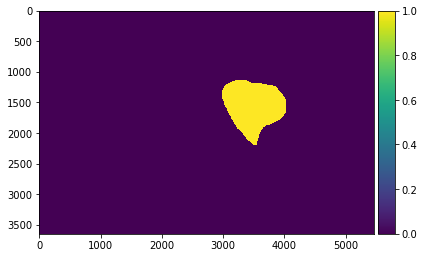

In [28]:
imshow(ground_truth[0,:,:])

In [ ]:
ground_truth[1,:,:,0].sum()